In [1]:
import os
import tensorflow as tf
from google.protobuf import text_format
from protos import pipeline_pb2
from modeling import trainer

image_dir = "/afs/cs.pitt.edu/usr0/key36/work2/WSSGG/data-vspnet/images"
model_dir = "/afs/cs.pitt.edu/usr0/key36/work2/WSSGG/logs/ws_prop50_adam0.00001"
config_file = os.path.join(model_dir, "pipeline.pbtxt")

for gpu in tf.config.experimental.list_physical_devices('GPU'):
  tf.config.experimental.set_memory_growth(gpu, True)

with tf.io.gfile.GFile(config_file, 'r') as fp: 
  pipeline_proto = text_format.Merge(fp.read(), pipeline_pb2.Pipeline())
batch_generator = trainer.predict(pipeline_proto, model_dir)

W0908 23:44:13.854628 140304727107392 model_fn.py:630] Estimator's model_fn (<function _create_model_fn.<locals>._model_fn at 0x7f9a500fcd08>) includes params argument, but params are not passed to Estimator.
W0908 23:44:14.474298 140304727107392 module_wrapper.py:139] From /afs/cs.pitt.edu/projects/kovashka/keren3/WSSGG/python/lib/python3.6/site-packages/tensorflow_core/python/autograph/converters/directives.py:119: The name tf.parse_single_example is deprecated. Please use tf.io.parse_single_example instead.

W0908 23:44:14.480209 140304727107392 module_wrapper.py:139] From /afs/cs.pitt.edu/projects/kovashka/keren3/WSSGG/python/lib/python3.6/site-packages/tensorflow_core/python/autograph/converters/directives.py:119: The name tf.sparse_tensor_to_dense is deprecated. Please use tf.sparse.to_dense instead.

W0908 23:44:15.926384 140304727107392 deprecation.py:323] From /afs/cs.pitt.edu/projects/kovashka/keren3/WSSGG/python/lib/python3.6/site-packages/tensorflow_core/contrib/layers/pyth

(-0.5, 499.5, 332.5, -0.5)

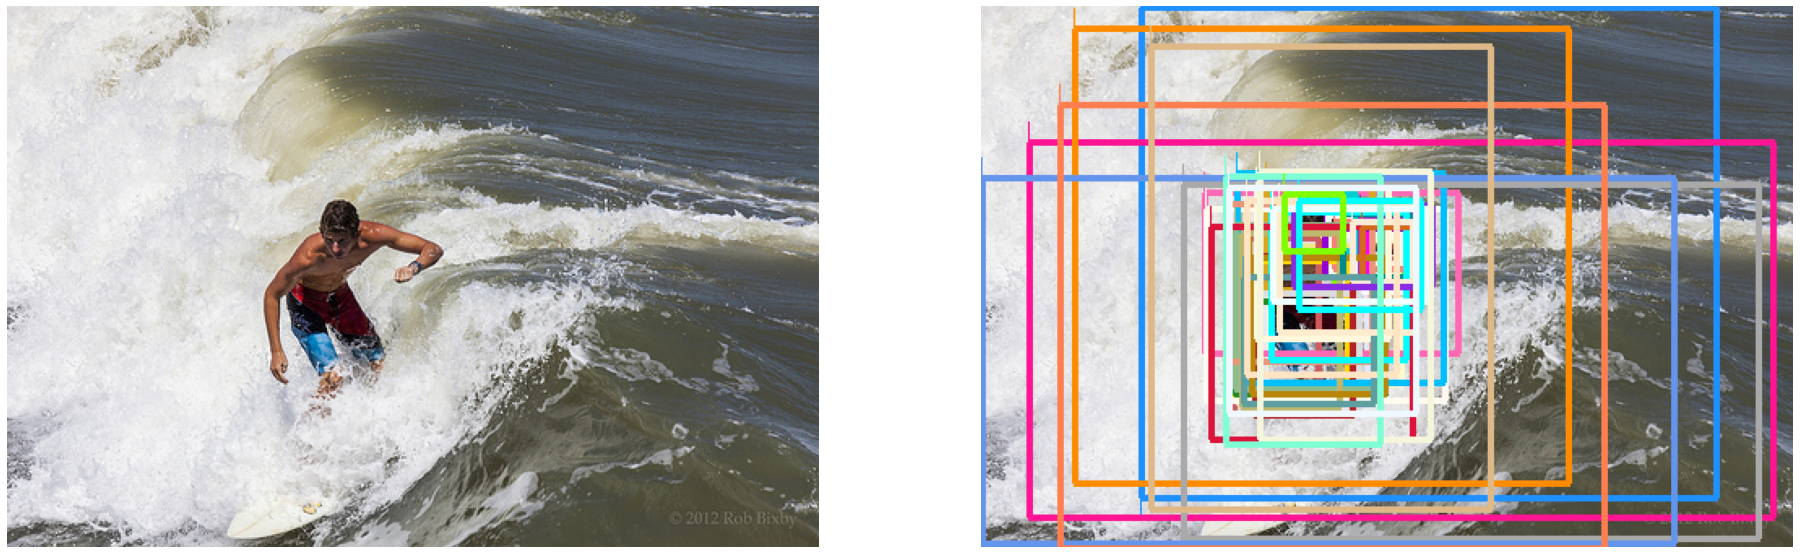

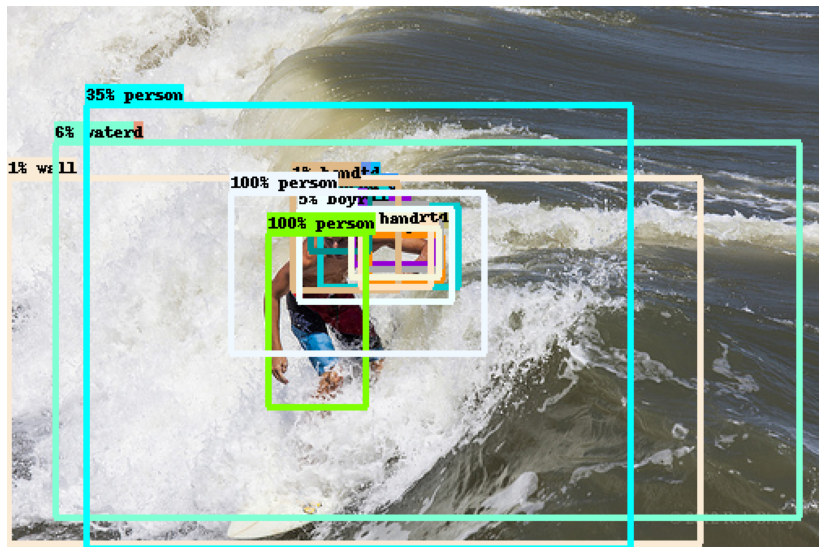

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
from modeling.utils import visualization

%matplotlib inline

try:
  i = next(example_id_generator)
except Exception as ex:
  example = next(batch_generator)
  example_id_generator = (i for i in range(len(example['id'])))
  i = next(example_id_generator)

image_id = example['id'][i]
n_proposal = example['image/n_proposal'][i]
proposals = example['image/proposal'][i]

# Ground-truth information.
n_triple = example['scene_graph/n_triple'][i]
predicates = example['scene_graph/predicate'][i][:n_triple]
subjects = example['scene_graph/subject'][i][:n_triple]
subject_boxes = example['scene_graph/subject/box'][i][:n_triple, :]
objects = example['scene_graph/object'][i][:n_triple]
object_boxes = example['scene_graph/object/box'][i][:n_triple, :]

# Pseudo box information.
pseudo_subject_boxes = example['pseudo/subject/box'][i][:n_triple, :]
pseudo_object_boxes = example['pseudo/object/box'][i][:n_triple, :]
pseudo_subject_scores = example['pseudo/mps_path/subject_to_proposal'][i][:n_triple]
pseudo_object_scores = example['pseudo/mps_path/proposal_to_object'][i][:n_triple]
pseudo_relation_scores = example['pseudo/mps_path/proposal_to_proposal'][i][:n_triple]

# Detection information
num_detections = example['refinement/num_detection'][i]
detection_boxes = example['refinement/detection_boxes'][i][:num_detections, :]
detection_classes = example['refinement/detection_classes'][i][:num_detections]
detection_scores = example['refinement/detection_scores'][i][:num_detections]

# Load original image.
image = Image.open(os.path.join(image_dir, '%i.jpg' % image_id))
image = np.array(image)

# Show original image.
plt.figure(figsize=(32, 16))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

# Show proposals.
image_with_proposals = visualization.draw_bounding_box_py_func_fn(
    image.copy(), n_proposal, proposals, None, None)
plt.subplot(1, 2, 2)
plt.imshow(image_with_proposals)
plt.axis('off')

# Show entity detections.
plt.figure(figsize=(32, 16))
image_with_entities = visualization.draw_bounding_box_py_func_fn(
    image.copy(), num_detections, detection_boxes, detection_classes, detection_scores)
plt.subplot(1, 2, 1)
plt.imshow(image_with_entities)
plt.axis('off')

# # Show ground-truth and predicted tuples.
# for triple_id, (pred, sub, sub_box, obj, obj_box, 
#                 ps_pred_score, ps_sub_box, ps_sub_score, ps_obj_box, ps_obj_score) in enumerate(
#     zip(predicates, subjects, subject_boxes, objects, object_boxes, 
#         pseudo_relation_scores, pseudo_subject_boxes, pseudo_subject_scores, pseudo_object_boxes, pseudo_object_scores)):
#   plt.figure(figsize=(16, 8))

#   # Ground-truth.
#   plt.subplot(1, 2, 1).set_title("%s-%s-%s" % (
#       sub.decode('ascii'), pred.decode('ascii'), obj.decode('ascii')))
#   image_with_triple = visualization.draw_bounding_box_py_func_fn(
#       image.copy(), 2, [sub_box, obj_box], [sub, obj], None)
#   image_with_triple = visualization.draw_arrow_py_func_fn(
#       image_with_triple, 1, [sub_box[0]], [sub_box[1]], [obj_box[0]], [obj_box[1]], [pred], None)
#   plt.imshow(image_with_triple)
#   plt.axis('off')

#   # Prediction.
#   plt.subplot(1, 2, 2).set_title("%s(%.2lf%%)-%s(%.4lf%%)-%s(%.2lf%%)" % (
#       sub.decode('ascii'), 100 * ps_sub_score, 
#       pred.decode('ascii'), 100 * ps_pred_score, 
#       obj.decode('ascii'), 100 * ps_obj_score))
#   image_with_pseudo = visualization.draw_bounding_box_py_func_fn(
#       image.copy(), 2, [ps_sub_box, ps_obj_box], [sub, obj], None)
#   image_with_pseudo = visualization.draw_arrow_py_func_fn(
#       image_with_pseudo, 1, [ps_sub_box[0]], [ps_sub_box[1]], [ps_obj_box[0]], [ps_obj_box[1]], [pred], None)
#   plt.imshow(image_with_pseudo)
#   plt.axis('off')